# Advanced Scoring of Graded Readers
## DS 7337 - Natural Language Processing - Homework 2 - Prime
### George C. Sturrock
### February 1, 2019
#### Homework 2 Prime Objectives
Homework 2 Prime is modification of Homework 2.  Instead of pulling a simple list of Graded Readers, this assignment will automate this task to extract the URLs of each of the Books of the Gutenberg Children's Instruction Bookshelf (http://www.gutenberg.org/wiki/Children%27s_Instructional_Books_(Bookshelf)) and use this list of URLs to read, cleanse and analyze the texts.

1.	In Python, create a method for scoring the vocabulary size of a text, and normalize the score from 0 to 1. It does not matter what method you use for normalization as long as you explain it in a short paragraph. 
2.	After consulting section 3.2 in chapter 1 of Bird-Klein, create a method for scoring the long-word vocabulary size of a text, and likewise normalize (and explain) the scoring as in step 1 above.
3.	Now create a “text difficulty score” by combining the lexical diversity score from homework 1, and your normalized score of vocabulary size and long-word vocabulary size, in equal weighting. Explain what you see when this score is applied to same graded texts used in homework 1.

#### Import Libraries

In [1]:
import platform; print("Platform:", platform.platform())
import os
import sys; print("Python:", sys.version)
import requests; print("Requests:", requests.__version__)
from urllib import request

import nltk; print("NLTK Version:", nltk.__version__)
from nltk.corpus import stopwords
theStopWords = set(stopwords.words('english'))

import numpy as np; print("Numpy Version:", np.__version__)
import pandas as pd; print("Pandas Version:", pd.__version__)
import matplotlib.pyplot as plt; #print("Matplotlib Pyplot Version:", plt.__version__)
import string; #print("String Version:", string.__version__)
import scipy.stats as stats; print("scipy version: 1.1.0")

import seaborn as sns; print("Seaborn Version:", sns.__version__)
sns.set(style='darkgrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup; print("BeatifulSoup Version: 4.6.3")

Platform: Linux-4.15.0-1027-gcp-x86_64-with-debian-stretch-sid
Python: 3.5.6 |Anaconda custom (64-bit)| (default, Aug 26 2018, 21:41:56) 
[GCC 7.3.0]
Requests: 2.19.1
NLTK Version: 3.3
Numpy Version: 1.15.2
Pandas Version: 0.23.4
scipy version: 1.1.0
Seaborn Version: 0.9.0
BeatifulSoup Version: 4.6.3


#### Scrape Gutenberg Website for Links to Text Documents for Graded Readers
The base site for text mining is the Gutenberg Children's Instructional Bookshelf.  This page contains the links for 104 readers for children of various ages and reading levels.  The first step is manually scraping the page for document links is to read the URL and parse the HTML code the links to the documents.  This process shown below creates a list with links to documents in the Children's Instructional Bookshelf.  

In [12]:
#retrieve html text
base_url = "http://www.gutenberg.org/wiki/Children%27s_Instructional_Books_(Bookshelf)"
response = requests.get(base_url)

#Search text for links to Gutenberg Readers
soup = BeautifulSoup(response.text, 'html.parser')
base_url_level1_href_tags = []
base_url_level1_href_tags = ["http:" + tag.attrs['href'] for tag in soup.find_all(href=True, class_='extiw')]

#Construct Links to Reader Text Documents
urlroot = "http://www.gutenberg.org/cache/epub/"
urlroot2 = "http://www.gutenberg.org/files/"

urllist = list()
urllist2 = list()

for b in base_url_level1_href_tags:
    docnum = (b.split('/'))[-1]
    urllist.append(urlroot+docnum+"/pg"+docnum+".txt")
    urllist2.append(urlroot2+docnum+"/"+docnum+"-0.txt")

#### Function to Transform Web Content to NLTK Tokens
The "nlpPipe" function create a code pipeline to transform html text into a tokenized set of words.  The pipeline removes punctuation, most licensing information, standard stop words as defined by NLTK and changes all text to lower case.  This functions returns the base information needed to produce the calculations specified in Homework 2 prime's objectives.  There are two noteable differences between Homework 2 and 2 prime.  First, an anomaly in the nlpPipe function was detected.  In Homework 2 prime, the "strip" list is initialized within the function to assure only the tokens within the URL provided to the function are returned.  Second, additional logic was added to remove more licensing, preface and other non-value add text values.

In [13]:
#credit to:
#https://chrisalbon.com/machine_learning/preprocessing_text/remove_stop_words/

strip = list()
table = str.maketrans('', '', string.punctuation)

def nlpPipe(htmlIn):
    #initialize variables
    strip = list()
    start = list()
    end = list()
    adv = 1
    #split html into lines
    html2 = htmlIn.splitlines()
    #Strip licensing from htmlIn
    
    if start == []:
        start = [i for i, s in enumerate(html2) if s.startswith("[Illustration]")]
    
    if start == []:
        start = [i for i, s in enumerate(html2) if s.startswith("BARBAULD")]
        
    if start == []:
        start = [i for i, s in enumerate(html2) if s.startswith("VOCABULARIO")]
    
    if start == []:
        start = [i for i, s in enumerate(html2) if s.startswith("CHAPITRE PREMIER")]
    
    if start == []:
        start = [i for i, s in enumerate(html2) if s.startswith("CHAPTER I")]
    
    if start == []:
        start = [i for i, s in enumerate(html2) if s.startswith("PART I")]
        
    if start == []:
        start = [i for i, s in enumerate(html2) if s.startswith("THE PUBLISHERS")]
    
#    if start == []:
#        start = [i for i, s in enumerate(html2) if s.startswith("[Illustration]")]
    
    if start == []:
        start = [i for i, s in enumerate(html2) if s.startswith("LESSON I")]
        
    if start == []:
        start = [i for i, s in enumerate(html2) if s.startswith("CONTENTS")
                 or s.startswith("~CONTENTS~")
                 or s.startswith("  CONTENTS")]

    if start == []:
        start = [i for i, s in enumerate(html2) if s.startswith("PREFACE")]

    if start == []:
        start = [i for i, s in enumerate(html2) if s.startswith("*** START OF THIS PROJECT GUTENBERG EBOOK") 
             or s.startswith("*** START OF THE PROJECT GUTENBERG EBOOK")
             or s.startswith("***START OF THE PROJECT GUTENBERG EBOOK")]
        adv = 9
    
    end = [i for i, s in enumerate(html2) if s.startswith("*** END OF THIS PROJECT GUTENBERG EBOOK") 
           or s.startswith("*** END OF THE PROJECT GUTENBERG EBOOK")
           or s.startswith("***END OF THE PROJECT GUTENBERG EBOOK")]
    
    text = html2[(start[0]+adv):(end[0]-4)]
    
    #strip end of line characters and convert to lower case
    for t in text:
        strip.append(t.rstrip().lower())
    
    #remove punctuation, remove stopwords with lambda functions and tokenize result
    raw = nltk.word_tokenize(str(strip))
    raw2 = [r.translate(table) for r in raw]
    rawx = [rx for rx in raw2 if rx not in theStopWords and rx.isalpha()]
    raw3 = nltk.Text(rawx)
    raw4 = raw3.tokens
    return raw4, html2[0], (len(set(raw4)));

#### Process Text from URLs

Children's Bookshelf texts are downloaded and submited to the nlpPipe function for processing.  The base dataframe "calcdf" for storing the results is created as well.  The logic accomodates for two different URL structures.  The primary structure is attempted first.  If primary URL cannot be reached, the second structure is used.  Any errors encountered during text downloading are printed below.

In [14]:
calcdf = pd.DataFrame(columns=["Title", "VocabSize", "LongWord", "UniqueWords"])

for u, u2 in zip(urllist, urllist2):
    nextUrl = True
    html = ''
    while nextUrl:
        try:
            html = request.urlopen(u).read().decode('utf8')
            nextUrl = False
        except Exception as e:
            print(e, u, "Trying Second URL")
            try:
                html = request.urlopen(u2).read().decode('utf8')
                nextUrl = False
            except Exception as e:
                print(e, u2)
                nextUrl = False

    tokens, title, unique = nlpPipe(html)
    
    #loop to identify and count words longer than 10 characters
    longword = 0
    for t in tokens:
        if len(t) > 10:
            longword += 1
    
    calcdf = calcdf.append({"Title": title[31:], "VocabSize": len(tokens), "LongWord": longword, "UniqueWords": unique}, 
                           ignore_index=True)
    

HTTP Error 404: Not Found http://www.gutenberg.org/cache/epub/23424/pg23424.txt Trying Second URL
HTTP Error 404: Not Found http://www.gutenberg.org/cache/epub/13853/pg13853.txt Trying Second URL
HTTP Error 404: Not Found http://www.gutenberg.org/cache/epub/22795/pg22795.txt Trying Second URL
HTTP Error 404: Not Found http://www.gutenberg.org/cache/epub/23424/pg23424.txt Trying Second URL
HTTP Error 404: Not Found http://www.gutenberg.org/cache/epub/18274/pg18274.txt Trying Second URL
HTTP Error 404: Not Found http://www.gutenberg.org/cache/epub/21973/pg21973.txt Trying Second URL
HTTP Error 404: Not Found http://www.gutenberg.org/cache/epub/15950/pg15950.txt Trying Second URL
'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte http://www.gutenberg.org/cache/epub/2441/pg2441.txt Trying Second URL
HTTP Error 404: Not Found http://www.gutenberg.org/cache/epub/24222/pg24222.txt Trying Second URL
HTTP Error 404: Not Found http://www.gutenberg.org/cache/epub/21783/pg21783

#### Calculations
Normalized Vocabulary Size, Lexical Diversity, Normalized Long Words and Text Difficulty are calculated below.  The calculations are simple operations which return interesting measurements to assist with text comparison.

In [15]:
calcdf["NormVocabSize"] = (calcdf.VocabSize / calcdf.VocabSize.max())
calcdf["LexDiversity"] = (calcdf.UniqueWords / calcdf.VocabSize)
calcdf["NormLongWord"] = (calcdf.LongWord / calcdf.LongWord.max())
calcdf["TextDifficulty"] = ((calcdf.NormVocabSize + calcdf.LexDiversity + calcdf.NormLongWord)/3)
calcdf

,Title,VocabSize,LongWord,UniqueWords,NormVocabSize,LexDiversity,NormLongWord,TextDifficulty
0,"A Primary Reader, by E. Louise Smythe",2347,31,505,0.0232448,0.215168,0.00452357,0.0809789
1,The Bird-Woman of the Lewis and Clark,4935,26,1063,0.0488764,0.2154,0.00379396,0.0893568
2,"Dr. Scudder's Tales for Little Readers,",15206,415,3866,0.150601,0.254242,0.0605574,0.155133
3,"The Louisa Alcott Reader, by Louisa M. Alcott",4843,55,1784,0.0479652,0.368367,0.00802568,0.141453
4,Boy Blue and His Friends,5715,50,1063,0.0566015,0.186002,0.00729607,0.0832998
5,"The Book of Nature Myths, by Florence Holbrook",14960,122,1548,0.148164,0.103476,0.0178024,0.0898142
6,The Flag of My Country. Shikéyah Bidah,682,80,262,0.00675455,0.384164,0.0116737,0.134197
7,"Elementary Science Readers, by Various",8784,96,1822,0.086997,0.207423,0.0140085,0.102809
8,"The Little Lame Prince, by",6678,130,2142,0.0661391,0.320755,0.0189698,0.135288
9,"Harry's Ladder to Learning, by Anonymous",5923,281,1905,0.0586616,0.321628,0.0410039,0.140431


### Question 1 - Scoring the Vocabulary Size of a Text
The raw vocabulary size of each text (calcdf.VocabSize) is represented by the count of words in each text as identified by the nlpPipe function.  This is normalized on a 0 to 1 scale by dividing the "VocabSize" by the maximum "VocabSize" from the dataframe.  The results are stored in calcdf.NormVocabSize.  The barchart below is sorted ascending by normalized vocabulary size shows how the individual texts rank with regards to normalized vocabulary size.  

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100]),
 <a list of 101 Text xticklabel objects>)

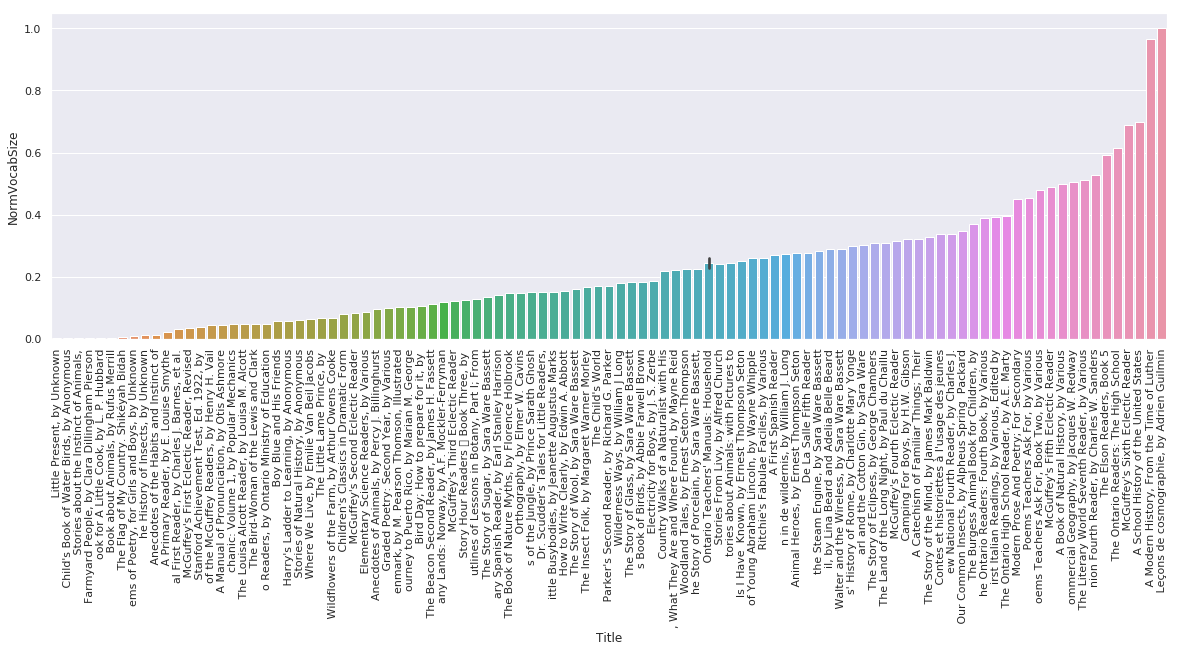

In [16]:
plt.figure(figsize=(20,6))
a = sns.barplot(data=calcdf.sort_values(by=['NormVocabSize']), x='Title', y='NormVocabSize')
plt.xticks(rotation=90)

### Question 2 - Normalized Long-Word Vocabulary Size
For purposes of this study, a long word is any word over 10 characters.  This number was obtained by taking the word length of the average word in English, which is approximately five characters, and doubling it.  The number of long words in each text are counted and stored in calcdf.LongWord.  The number of long words per text is then divided by the maximum long word value in calcdf to produce the normalized long word score.  The joint plot shown below illustrates the relationship between Normalized Vocabulary Size and Normalized Long Word.  The distribution plot opposite the labels on the x and y axes shows Normalized Long Word is right skewed while Normalized Vocabulary Score is slightly right skewed.  Additionally, the scatter plot with linear regression line illustrate the positive relationship between Normalized Vocabulary Size and Normalized Long Word.  The Pearson's R score of 0.85 offers statistical proof of the positive correlation between the two variables.  The p-value of 9e-31 is suggests the relationship between Normalized Vocabulary Size and Normalized Long Word is statistically significant

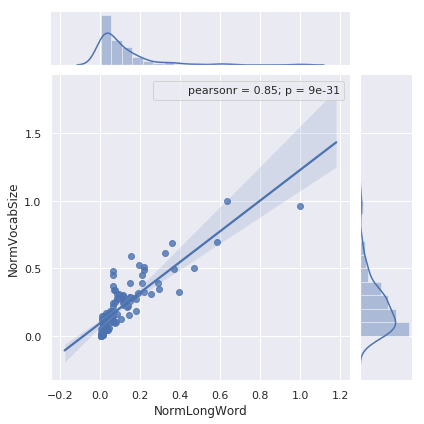

In [17]:
g = sns.jointplot(x=calcdf.NormLongWord.astype(float), y=calcdf.NormVocabSize.astype(float), kind="reg")
g.annotate(stats.pearsonr)

### Question 3 - Text Difficulty Score
The text difficulty score combines the lexical diversity score from Homework 1 with the normalized long word and normalized vocabulary size introduced in this assignment.  The three variables are added together and divided by three to produce an evenly weighted result.  In Homework 1, McGuffey's First, Third and Sixth Eclectic Readers where analyzed.  These show Lexical Diversity decreases as vocabulary size increases.  The sliced dataframe shown below shows an inverse relationship between Lexical Diversity and Text Difficulty for the three texts analyzed in Homework 1.  

In [18]:
calcdf.iloc[[16,18,21]]

,Title,VocabSize,LongWord,UniqueWords,NormVocabSize,LexDiversity,NormLongWord,TextDifficulty
16,"McGuffey's First Eclectic Reader, Revised",3607,66,849,0.0357238,0.235376,0.00963082,0.0935768
18,McGuffey's Third Eclectic Reader,12267,66,3024,0.121493,0.246515,0.00963082,0.12588
21,McGuffey's Sixth Eclectic Reader,69565,2471,13701,0.688974,0.196952,0.360572,0.415499


Broader examination of the set of texts ingested from the Children's Bookshelf appears to show no relationship between Lexical Diversity and Text Difficulty.  The grouped bar plot below displays this relationship.

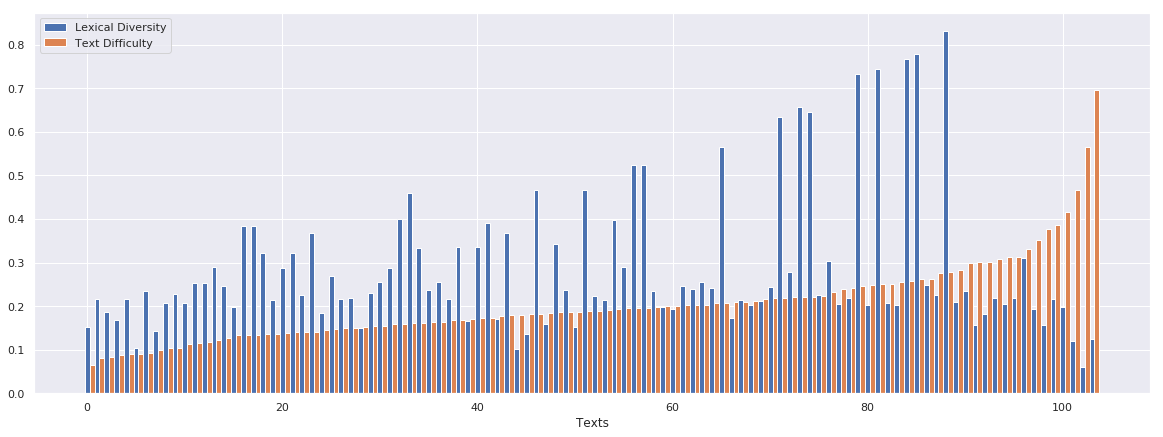

In [19]:
df = calcdf.sort_values(by=['TextDifficulty'])
barWidth = 0.5
b1 = np.arange(len(calcdf.LexDiversity))
b2 = [x + barWidth for x in b1]
plt.figure(figsize=(20,7))
plt.bar(b1, df.LexDiversity, width=barWidth, label="Lexical Diversity")
plt.bar(b2, df.TextDifficulty, width=barWidth, label="Text Difficulty")
#plt.bar([x + barWidth for x in b2], calcdf.NormLongWord, width=barWidth, label="Norm Long Word")
plt.xlabel("Texts")
plt.legend(loc='upper left')
plt.show()

Futher examination between Lexical Diversity and Text Difficulty is done using a joint plot.  Both variables are normally distributed.  The regression line does show a decrease in Lexical Diversity as Text Difficulty increases.  However, the Pearson's R score of -0.037 suggests a week negative correlations between Lexical Diversity and Text Difficulty.  The p-value of 0.71 shows the relationship between Lexical Diversity and Text Difficulty is not statistically significant.  

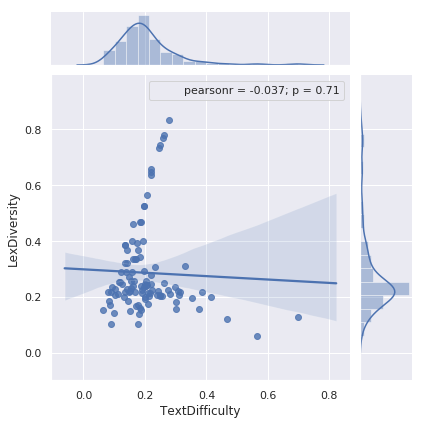

In [20]:
g = sns.jointplot(y=calcdf.LexDiversity.astype(float), x=calcdf.TextDifficulty.astype(float), kind="reg")
g.annotate(stats.pearsonr)